### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 1000  # upper limit of integral # 5
nbit = 10  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 3.289861639787202e-06
Discretized Result: 3.289860855402632e-06


In [3]:
import sys
sys.path.append('../libmitigation')

In [4]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [5]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


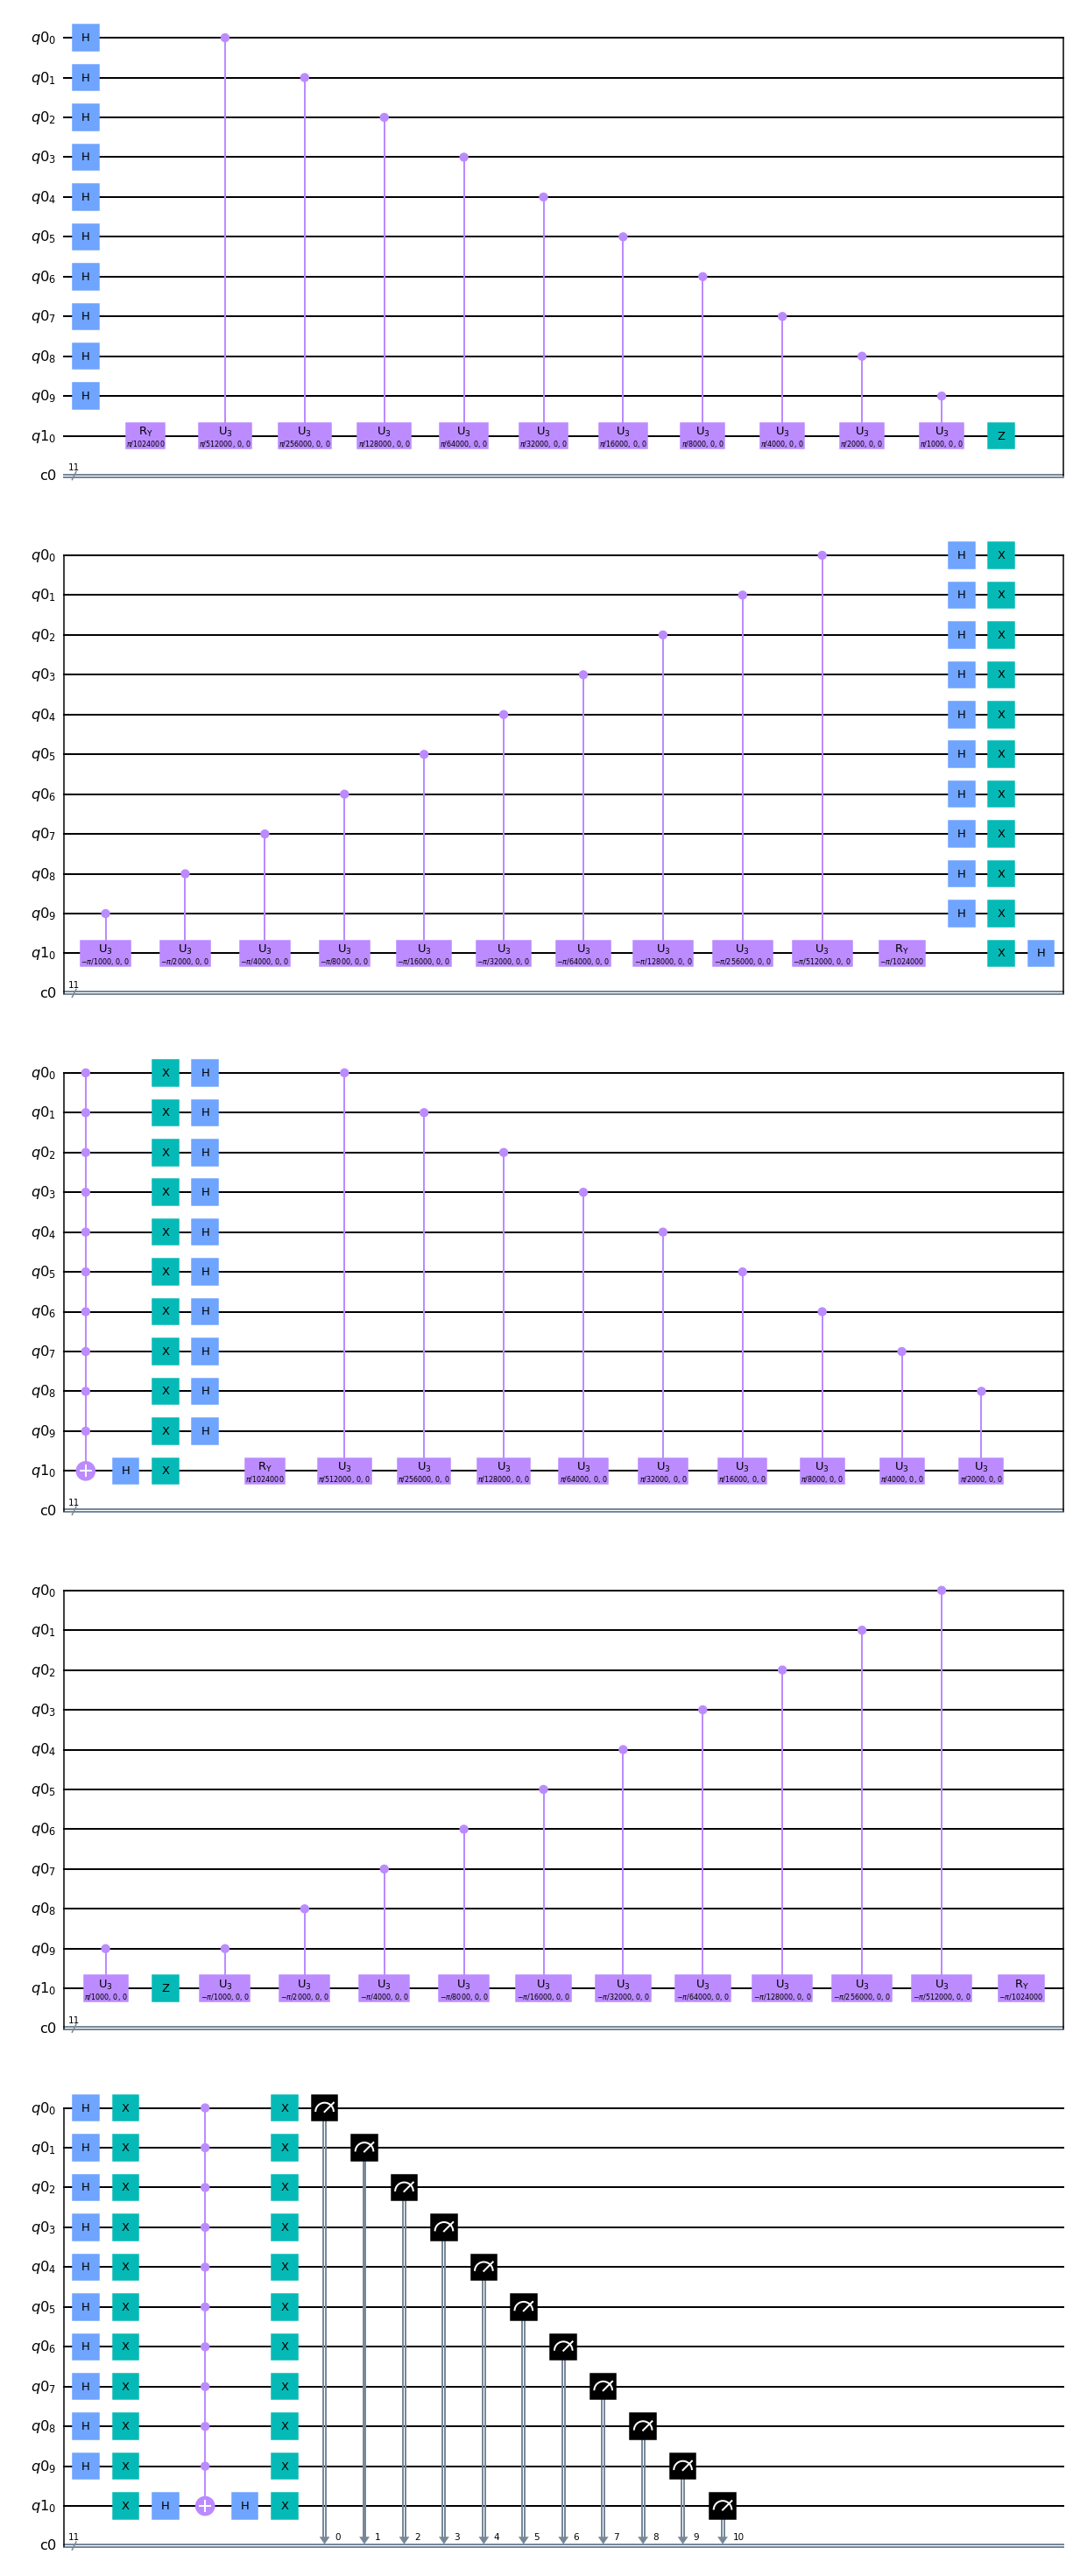

In [8]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [11]:
#setting the number of shots and Grover operators.

number_grover_list = [0, 1, 2, 4, 8, 16, 32, 64, 128] # list of number of Grover operators
# number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [12]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.93, 0.07],[0.07,0.93]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [13]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [14]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
2.424860954284668 s
1 th round with 1 oracles
0.044503211975097656 s
2 th round with 2 oracles
0.06701803207397461 s
3 th round with 3 oracles
0.09860873222351074 s
4 th round with 4 oracles
0.12294983863830566 s
5 th round with 5 oracles
0.16143584251403809 s
6 th round with 6 oracles
0.1935579776763916 s
7 th round with 7 oracles
0.2076878547668457 s
8 th round with 8 oracles
0.20613384246826172 s
9 th round with 9 oracles
0.19411802291870117 s
10 th round with 10 oracles
0.20215797424316406 s
11 th round with 11 oracles
0.2068309783935547 s
12 th round with 12 oracles
0.19385600090026855 s
13 th round with 13 oracles
0.2144770622253418 s
14 th round with 14 oracles
0.2247631549835205 s
15 th round with 15 oracles
0.32736921310424805 s
16 th round with 16 oracles
0.38678407669067383 s
17 th round with 17 oracles
0.34194278717041016 s
18 th round with 18 oracles
0.2706601619720459 s
19 th round with 19 oracles
0.3009462356567383 s
20 th round with 20 oracles


In [15]:
import pickle
with open("raw_result_p007_q007_piover1000.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [16]:
import pickle
with open("raw_result_p007_q007_piover1000.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [17]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[44, 42, 46, 55, 42, 46, 45, 52, 43, 43, 50, 43, 47, 46, 36, 42, 42, 51, 42, 49, 50, 42, 39, 34, 51, 39, 46, 41, 51, 49, 47, 45, 36, 53, 49, 45, 46, 47, 49, 54, 41, 39, 40, 44, 38, 53, 43, 45, 41, 46, 44, 38, 50, 41, 36, 34, 38, 33, 43, 43, 41, 41, 41, 48, 51, 48, 44, 44, 51, 32, 37, 49, 38, 46, 42, 39, 42, 40, 40, 50, 37, 38, 50, 31, 41, 37, 42, 43, 39, 47, 41, 50, 35, 34, 40, 43, 40, 41, 45, 48]


In [19]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [20]:
meas_filter = InvSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
mit_counts_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    mit_counts_list.append(x_tilde)
mit_hit_list = make_hit_list(mit_counts_list)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999997
number of positive values:  1021
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999971
number of positive values:  1035
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999968
number of positive values:  1035
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999974
number of positive values:  1022
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999972
number of positive values:  1031
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999974
number of positive values:  1031
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999994
number of positive values:  1051
main process: Done!
strict

sum of mitigated probability vector x: 0.9999999999999961
number of positive values:  1027
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999964
number of positive values:  1027
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.999999999999997
number of positive values:  1005
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999946
number of positive values:  1025
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999981
number of positive values:  1027
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999972
number of positive values:  1029
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999953
number of positive values:  1046
main process: Done!
strict inverse + SGS algorithm
sum of 

In [21]:
meas_filter = InvSSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_list.append(x_tilde)
mit_hit_S_list = make_hit_list(x_tilde_S_list)
print(mit_hit_S_list)

Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.41722848611806
number of positive values:  25
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.3676361117019777
number of positive values:  26
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.334103363416411
number of positive values:  19
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.3170311784995938
number of positive values:  15
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4813155304028967
number of positive values:  25
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.343799838174344
number of positive values:  18
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x

sum of mitigated probability vector x_s: 1.4517268163104615
number of positive values:  30
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.5163023338892712
number of positive values:  32
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4338426295242712
number of positive values:  22
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4156234591952943
number of positive values:  25
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4197047500662772
number of positive values:  20
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.4068700876254818
number of positive values:  24
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.390105669916479
number of positiv

In [22]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.41722848611806
sum of mitigated probability vector x_hat_s: 1.4170419604297926
number of positive values:  25
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.3676361117019777
sum of mitigated probability vector x_hat_s: 1.3674521486529922
number of positive values:  26
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.334103363416411
sum of mitigated probability vector x_hat_s: 1.333943460835948
number of positive values:  19
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.3170311784995938
sum of mitigated probability vector x_hat_s: 1.3168822067993111
number of positive values:  15
main process: Done!
Restriction to labels of y + Lagrange Multip

sum of mitigated probability vector x_s: 1.411376794021149
sum of mitigated probability vector x_hat_s: 1.411215060362318
number of positive values:  20
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2943151944524114
sum of mitigated probability vector x_hat_s: 1.294144810440152
number of positive values:  21
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4191126442072322
sum of mitigated probability vector x_hat_s: 1.4189379327282317
number of positive values:  20
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4148564743321523
sum of mitigated probability vector x_hat_s: 1.4146826045986403
number of positive values:  22
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.

sum of mitigated probability vector x_s: 1.3746281555631423
sum of mitigated probability vector x_hat_s: 1.3744511172196798
number of positive values:  25
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.483386030540161
sum of mitigated probability vector x_hat_s: 1.4832255462278114
number of positive values:  26
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4321251465093283
sum of mitigated probability vector x_hat_s: 1.4319591373300962
number of positive values:  27
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.403214936496775
sum of mitigated probability vector x_hat_s: 1.4030342157784585
number of positive values:  25
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1

In [23]:
import pickle
with open("hit_list_p007_q007_piover1000.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [24]:
import pickle
with open("mit_hit_list_p007_q007_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_list, f)

In [25]:
import pickle
with open("mit_hit_S_list_p007_q007_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_S_list, f)

In [26]:
import pickle
with open("mit_hit_S_lm_0_list_p007_q007_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

Text(0, 0.5, 'number of shots for $|00...0>$')

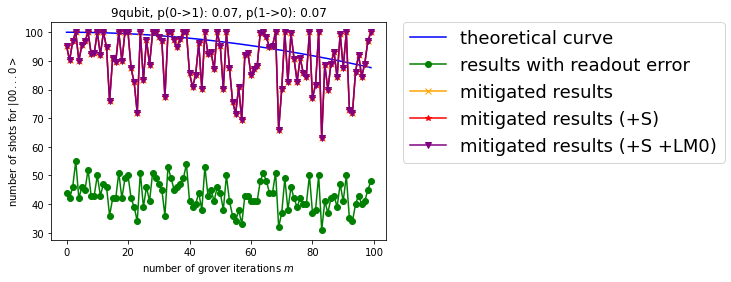

In [27]:
divide = 100
# plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, 100 * np.cos(2 * np.array(number_grover_list) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_list, marker="x", label="mitigated results", color="orange")
plt.plot(number_grover_list, mit_hit_S_list, marker="*", label="mitigated results (+S)", color="red")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("9qubit, p(0->1): 0.07, p(1->0): 0.07")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

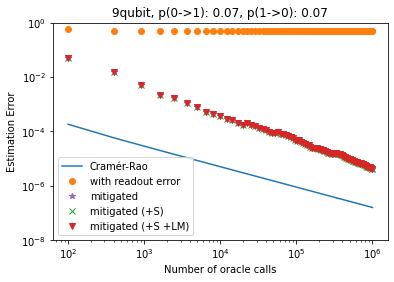

In [29]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_list = [100 - h for h in mit_hit_list]
sin_mit_hit_S_list = [100 - h for h in mit_hit_S_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_list = calculate_theta(
    sin_mit_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_list = calculate_theta(
    sin_mit_hit_S_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_list = np.abs(np.sin(thetaCandidate_mit_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_list = np.abs(np.sin(thetaCandidate_mit_S_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

In [ ]:
p = plt.plot( OracleCall_list, ErrorCramérRao_list)
p0 = plt.plot( OracleCall_list, error_list, 'o')
p1 = plt.plot( OracleCall_list, error_mit_list, '*', color='C4')
p2 = plt.plot( OracleCall_list, error_mit_S_list, 'x', color='C2')
p3 = plt.plot( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3')

plt.title("9qubit, p(0->1): 0.07, p(1->0): 0.07")
plt.xscale('log')
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.yscale('log')
plt.ylabel("Estimation Error")
plt.legend((p[0], p0[0], p1[0], p2[0], p3[0]), ("Cramér-Rao", "with readout error", "mitigated", "mitigated (+S)", "mitigated (+S +LM)"))
plt.show()

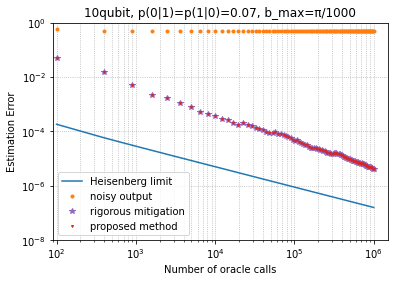

In [30]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p1 = plt.loglog( OracleCall_list, error_mit_list, '*', color='C4', markersize=6)
# p2 = plt.plot( OracleCall_list, error_mit_S_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("10qubit, p(0|1)=p(1|0)=0.07, b_max=π/1000")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p1[0], p3[0]), ("Heisenberg limit", "noisy output", "rigorous mitigation", "proposed method"))
plt.show()